In [1]:
from datasets import SinusoidDataset
from models import MLPCNF
from lightning import Trainer
from lightning.pytorch.callbacks import RichModelSummary

In [2]:
dataset = SinusoidDataset(
    sample_rate=1.0,
    observation_time=16,
    noise_cov=0.1,
)
model = MLPCNF(
    dim=3,
    obs_dim=len(dataset.observation_times),
    hidden_dim=1024,
    depth=4,
    lr=3e-4,
)
train_dataloader = dataset.dataloader(
    batch_size=16*1024,
    batches=1024,
    num_workers=16,
    persistent_workers=True,
    #pin_memory=True,
)
trainer = Trainer(
    #accelerator="cpu",
    devices="0,",
    max_epochs=10,
    callbacks=[RichModelSummary()],
)
trainer.fit(model, train_dataloader)

Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.rich_model_summary.RichModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX A6000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]


┏━━━┳━━━━━━┳━━━━━━┳━━━━━━━━┓
┃   ┃ Name ┃ Type ┃ Params ┃
┡━━━╇━━━━━━╇━━━━━━╇━━━━━━━━┩
│ 0 │ flow │ MLP  │  3.2 M │
└───┴──────┴──────┴────────┘

Trainable params: 3.2 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 3.2 M                                                                                                
Total estimated model params size (MB): 12

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


  0%|          | 0/10 [00:00<?, ?it/s]

Pushing data through flow
Running MCMC sampling


100%|██████████| 300/300 [00:03<00:00, 77.03it/s]


Finished initial run, burn-in dropped and starting real run


100%|██████████| 512/512 [00:06<00:00, 77.86it/s]


Pushing data through flow
Running MCMC sampling


100%|██████████| 300/300 [00:03<00:00, 77.82it/s]


Finished initial run, burn-in dropped and starting real run


100%|██████████| 512/512 [00:06<00:00, 78.21it/s]


Pushing data through flow
Running MCMC sampling


100%|██████████| 300/300 [00:03<00:00, 77.35it/s]


Finished initial run, burn-in dropped and starting real run


100%|██████████| 512/512 [00:06<00:00, 77.78it/s]


Pushing data through flow
Running MCMC sampling


100%|██████████| 300/300 [00:03<00:00, 77.36it/s]


Finished initial run, burn-in dropped and starting real run


100%|██████████| 512/512 [00:06<00:00, 76.96it/s]


Pushing data through flow
Running MCMC sampling


100%|██████████| 300/300 [00:03<00:00, 76.74it/s]


Finished initial run, burn-in dropped and starting real run


100%|██████████| 512/512 [00:06<00:00, 76.46it/s]


Pushing data through flow
Running MCMC sampling


100%|██████████| 300/300 [00:03<00:00, 78.98it/s]


Finished initial run, burn-in dropped and starting real run


100%|██████████| 512/512 [00:06<00:00, 79.74it/s]


Pushing data through flow
Running MCMC sampling


100%|██████████| 300/300 [00:03<00:00, 79.06it/s]


Finished initial run, burn-in dropped and starting real run


100%|██████████| 512/512 [00:06<00:00, 79.71it/s]


Pushing data through flow
Running MCMC sampling


100%|██████████| 300/300 [00:03<00:00, 75.90it/s]


Finished initial run, burn-in dropped and starting real run


100%|██████████| 512/512 [00:06<00:00, 77.69it/s]


Pushing data through flow
Running MCMC sampling


100%|██████████| 300/300 [00:04<00:00, 72.01it/s]


Finished initial run, burn-in dropped and starting real run


100%|██████████| 512/512 [00:07<00:00, 72.54it/s]


Pushing data through flow
Running MCMC sampling


100%|██████████| 300/300 [00:03<00:00, 77.37it/s]


Finished initial run, burn-in dropped and starting real run


100%|██████████| 512/512 [00:06<00:00, 77.20it/s]


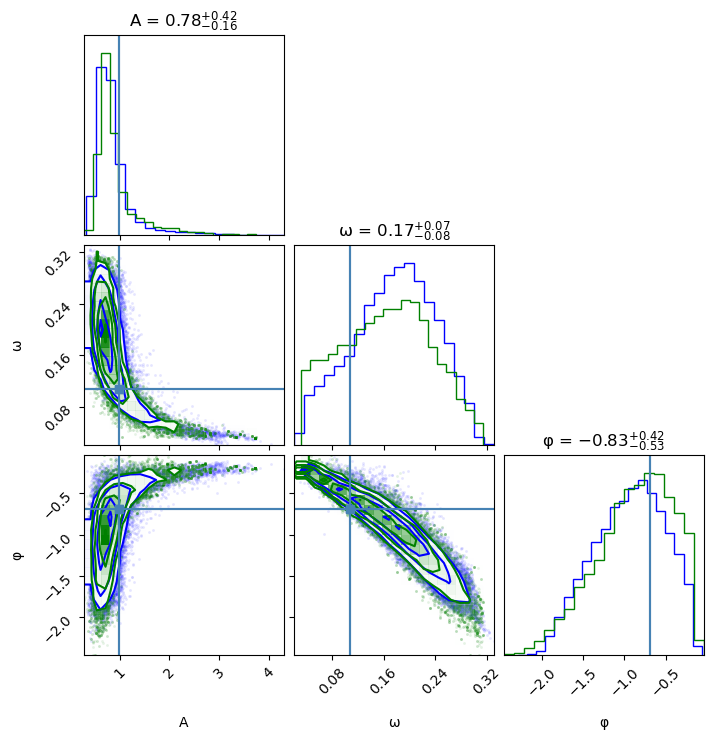

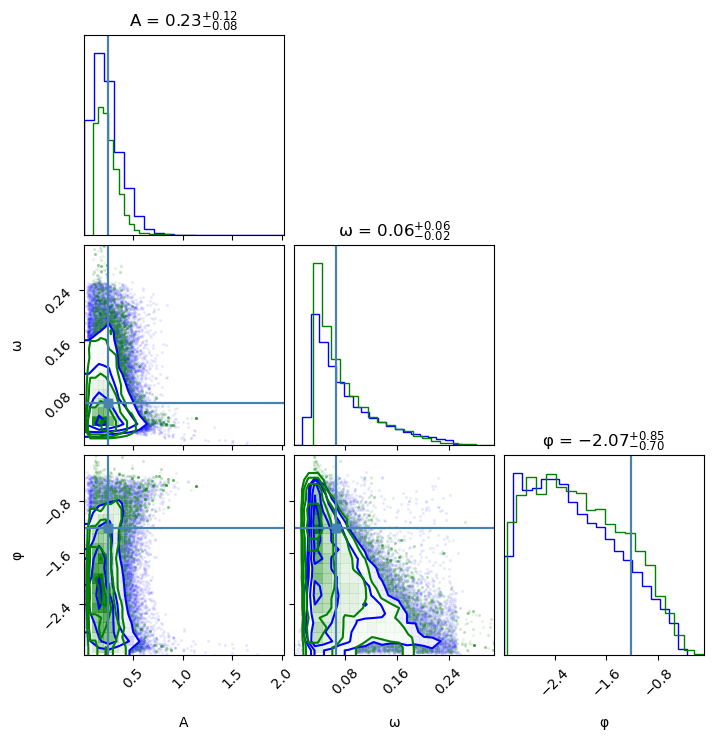

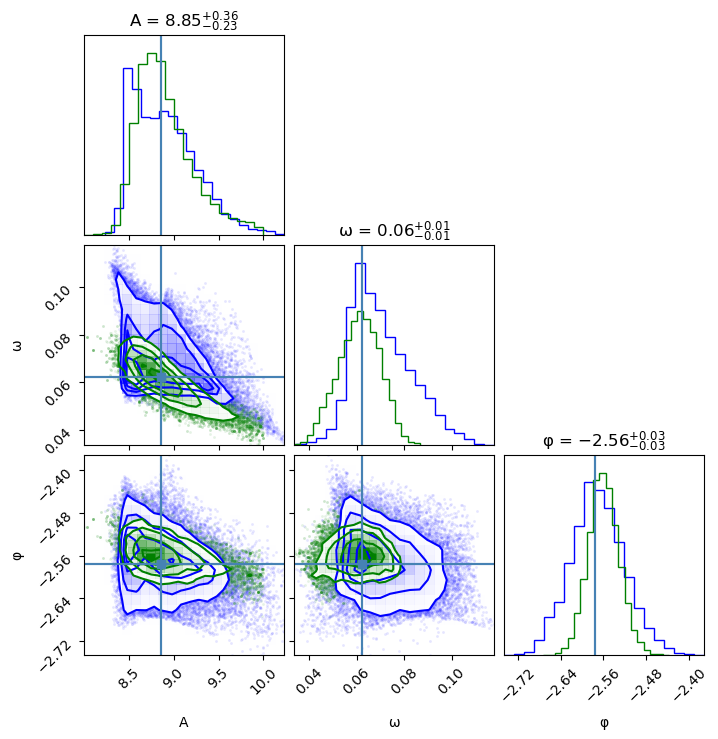

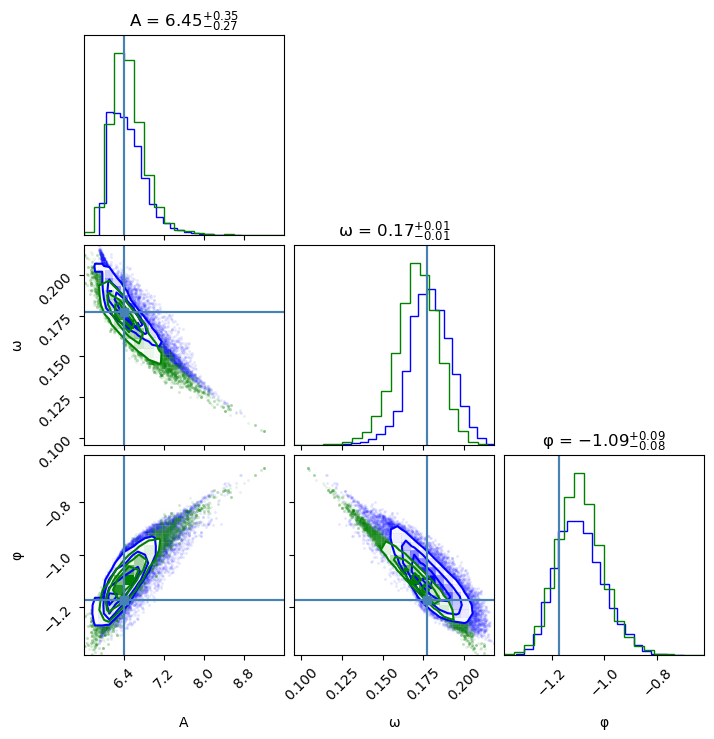

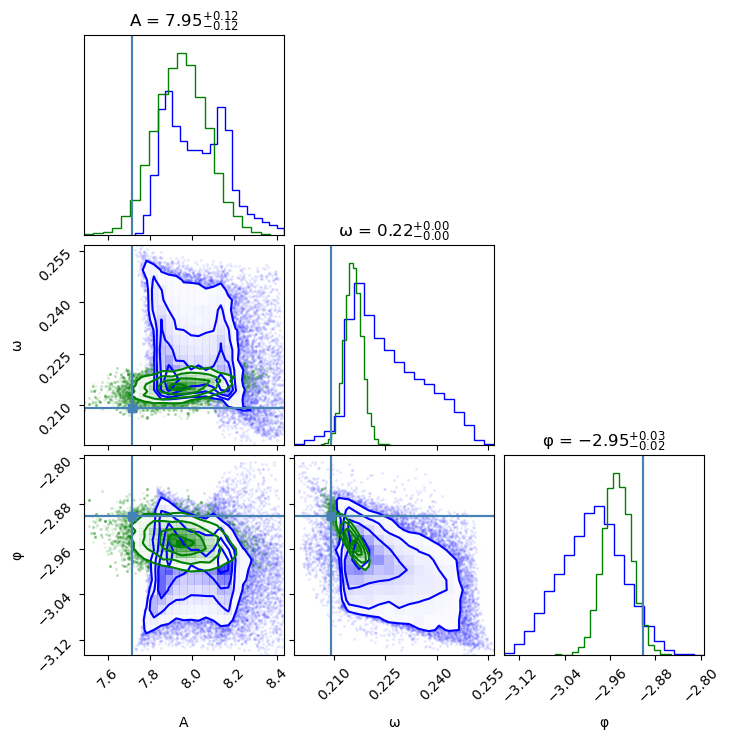

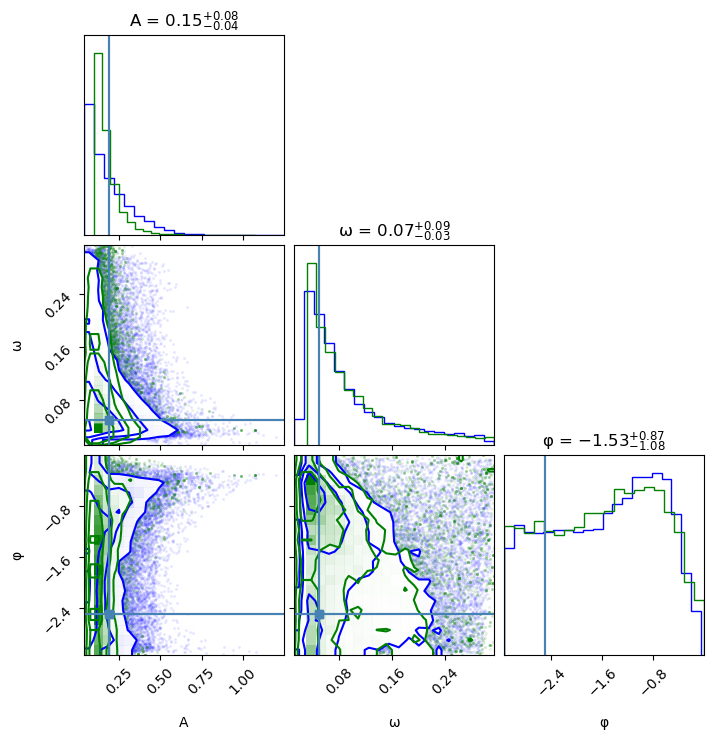

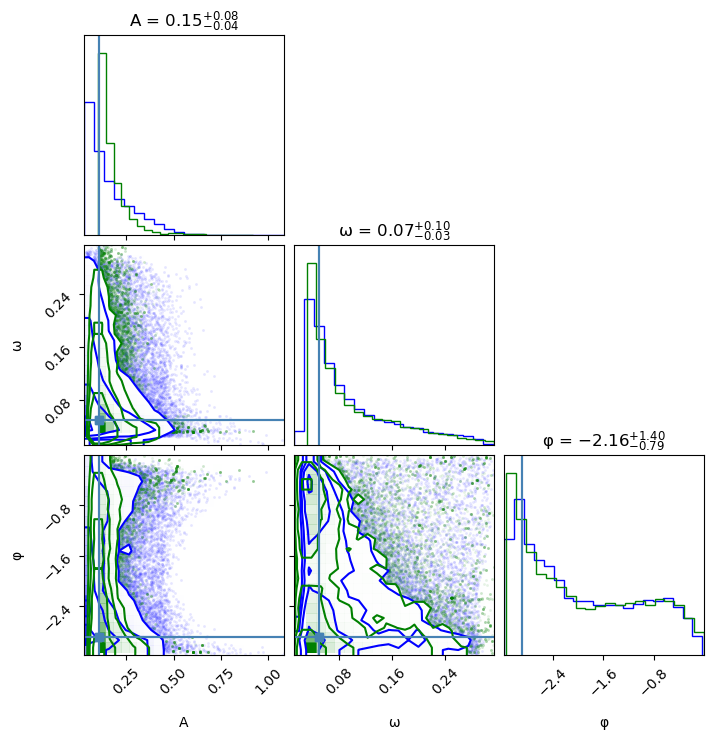

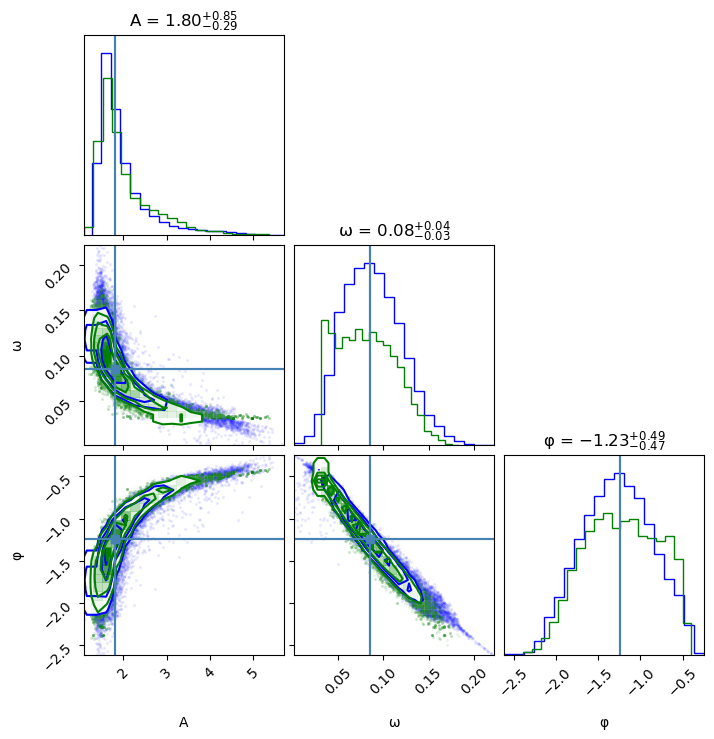

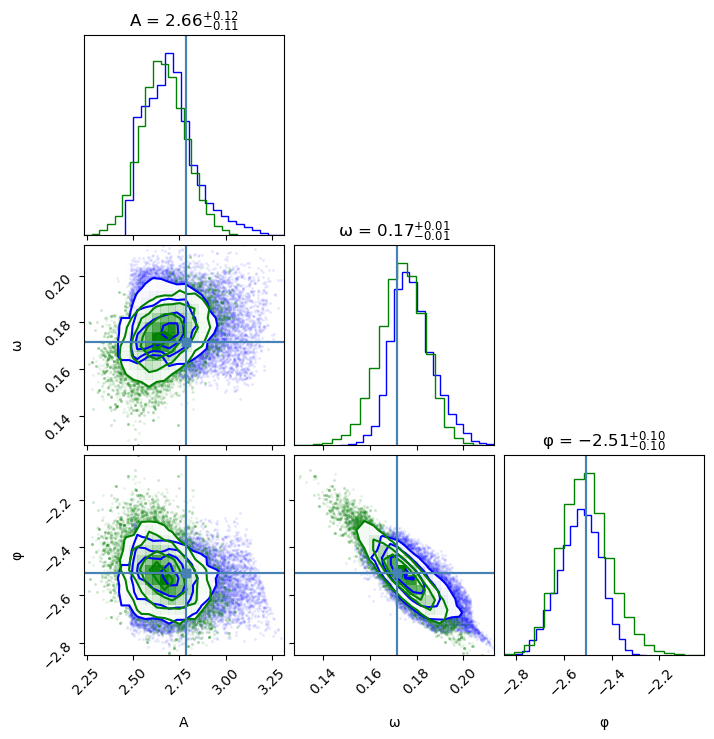

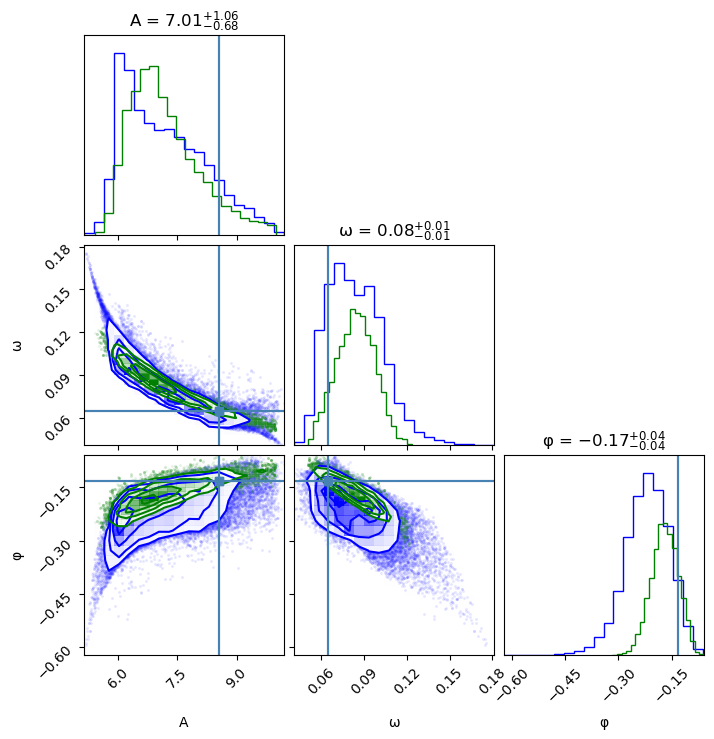

In [3]:
from utils import corner_plot
corner_plot(dataset, model, examples=10, samples=32*1024, verbose=True)

In [2]:
import jax
import jax.numpy as jnp

In [7]:
amp_range = (0.1, 10)
omg_range = (0.01 * jnp.pi, 0.1 * jnp.pi)
phi_range = (-jnp.pi, jnp.pi)
noise_cov = 0.1 * jnp.eye(len(dataset.observation_times))


def log_prior(x):
    amp, omg, phi = jnp.split(x, 3, axis=-1)
    log_prior_amp = -jnp.log(amp * jnp.log(amp_range[1] / amp_range[0]))
    log_prior_omg = -jnp.log(omg * jnp.log(omg_range[1] / omg_range[0]))
    log_prior_phi = jnp.where(
        (phi < 0) * (phi > 2) * jnp.pi, -jnp.inf, -jnp.log(2 * jnp.pi)
    )
    return (log_prior_amp + log_prior_omg + log_prior_phi).squeeze(-1)


def clean_signal(x):
    amp, omg, phi = jnp.split(x, 3, axis=-1)
    t = jnp.arange(0.0, 16.0, 1.0)
    y = amp * jnp.sin(omg * t + phi)
    return y


def log_likelihood(x, y):
    delta = y[..., 0] - clean_signal(x)
    res = jax.scipy.stats.multivariate_normal.logpdf(delta, delta * 0.0, cov=noise_cov)
    return res

In [9]:
import blackjax
from tqdm import tqdm
from datasets import SinusoidDataset

dataset = SinusoidDataset(
    sample_rate=1.0,
    observation_time=16,
    noise_cov=0.1,
)


for t, x0, x1, y in tqdm(dataset.dataloader(batch_size=32*1024, batches=3)):
    y, x_true = jnp.array(y[0]), jnp.array(x1[0])
    
    def logdensity_fn(x):
        return log_prior(x) + log_likelihood(x, y)

    # Build the kernel
    step_size = 1e-3
    inverse_mass_matrix = jnp.array([1., 1., 1.])
    nuts = blackjax.nuts(logdensity_fn, step_size, inverse_mass_matrix)

    # Initialize the state    
    state = nuts.init(x_true)
    # Iterate
    rng_key = jax.random.key(0)
    step = jax.jit(nuts.step)
    for i in tqdm(range(10)):
        nuts_key = jax.random.fold_in(rng_key, i)
        state, out = step(nuts_key, state)
    print(out)


 33%|███▎      | 1/3 [00:01<00:02,  1.47s/it]

NUTSInfo(momentum=Array([ 0.15774037, -0.13519911,  0.64584076], dtype=float32), is_divergent=Array(True, dtype=bool), is_turning=Array(False, dtype=bool), energy=Array(3.2698193, dtype=float32), trajectory_leftmost_state=IntegratorState(position=Array([ 0.7146196 ,  0.01061528, -1.6689978 ], dtype=float32), momentum=Array([0.17372957, 0.2524522 , 0.64978176], dtype=float32), logdensity=Array(-3.0102425, dtype=float32), logdensity_grad=Array([ -3.9412713, -98.60169  ,  -0.9684452], dtype=float32)), trajectory_rightmost_state=IntegratorState(position=Array([ 0.7169829 , -0.00407991, -1.6580805 ], dtype=float32), momentum=Array([ 0.10391525, -4.3514137 ,  0.63713545], dtype=float32), logdensity=Array(nan, dtype=float32), logdensity_grad=Array([-3.731660e+00,  2.564452e+02,  1.695106e-01], dtype=float32)), num_trajectory_expansions=Array(5, dtype=int32, weak_type=True), num_integration_steps=Array(17, dtype=int32, weak_type=True), acceptance_rate=Array(0.8867863, dtype=float32))


 67%|██████▋   | 2/3 [00:02<00:01,  1.44s/it]

NUTSInfo(momentum=Array([ 0.15774037, -0.13519911,  0.64584076], dtype=float32), is_divergent=Array(False, dtype=bool), is_turning=Array(True, dtype=bool), energy=Array(4.7429495, dtype=float32), trajectory_leftmost_state=IntegratorState(position=Array([ 3.3709726 ,  0.22944757, -0.03557609], dtype=float32), momentum=Array([0.22200178, 0.7254636 , 0.8819678 ], dtype=float32), logdensity=Array(-4.067288, dtype=float32), logdensity_grad=Array([-1.3160356, 91.28757  ,  8.324236 ], dtype=float32)), trajectory_rightmost_state=IntegratorState(position=Array([3.3816772 , 0.22715145, 0.0077955 ], dtype=float32), momentum=Array([ 0.04898568, -0.85746294,  0.14533927], dtype=float32), logdensity=Array(-4.363656, dtype=float32), logdensity_grad=Array([ -3.365124, -33.551365, -17.711304], dtype=float32)), num_trajectory_expansions=Array(7, dtype=int32, weak_type=True), num_integration_steps=Array(71, dtype=int32, weak_type=True), acceptance_rate=Array(0.9999963, dtype=float32))


100%|██████████| 3/3 [00:04<00:00,  1.54s/it]

NUTSInfo(momentum=Array([ 0.15774037, -0.13519911,  0.64584076], dtype=float32), is_divergent=Array(False, dtype=bool), is_turning=Array(True, dtype=bool), energy=Array(3.8509896, dtype=float32), trajectory_leftmost_state=IntegratorState(position=Array([ 6.3513865 ,  0.02753184, -2.438416  ], dtype=float32), momentum=Array([ 0.13606884, -1.272815  ,  0.57645375], dtype=float32), logdensity=Array(-2.855016, dtype=float32), logdensity_grad=Array([ -1.5028108, -19.021229 , -14.060932 ], dtype=float32)), trajectory_rightmost_state=IntegratorState(position=Array([ 6.3537135 ,  0.02834195, -2.429312  ], dtype=float32), momentum=Array([ 0.11196442, -1.0099797 ,  0.35863823], dtype=float32), logdensity=Array(-3.27009, dtype=float32), logdensity_grad=Array([  -8.872631, -265.21835 ,  -48.527855], dtype=float32)), num_trajectory_expansions=Array(4, dtype=int32, weak_type=True), num_integration_steps=Array(15, dtype=int32, weak_type=True), acceptance_rate=Array(1.0000001, dtype=float32))
